
This notebook contains code we use to to generate `train/val/test` split and format the datasets we use as `TFRecords`. 


Each record will be encoded as:

  * `im_id`, the image identifier, used to resolve the filepath
  * `num_boxes`, the number of valid boxes in the image
  * `bounding boxes`, the list of bounding boxes in the image. Empty boxes are represented as [1, 1, 0, 0]. 
    Padded to the shape `(max_number_bounding_boxes, 4)`. Thje format is (xmin, ymin, xmax, ymax)
  * `classes`, the list of classes for each box. -1 if empty box.

This information is further parsed in `include/tf_inputs.py`, which in particular will take care of computing the missing group ground-truth on the fly.

In [2]:
%matplotlib inline
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import io
import time
import shlex
from collections import defaultdict
from math import ceil, floor

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage.transform import resize

import numpy as np
import tensorflow as tf
print(tf.__version__)

from include import configuration
from include import graph_manager
from include import tf_inputs
from include import utils
from include import tfrecords_utils
from include import viz

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

1.4.0


In [6]:
def write_data_to_tfrecords(image_ids, image_annotations, output_file, pad=None, split=None):
    """Write the TFRecords
    
    Args:
        image_ids: List of image_ids
        image_annotations: Triples of list, each with the same size as image_ids
        output_file: output path for the TFRecords
        pad: If given, pad to the maximum number of bounding boxes
        split: Restrict the image ids to use
    """
    with_classes = (len(image_annotations) == 3)
    if with_classes:
        feature_keys = ['im_id', 'num_boxes', 'bounding_boxes', 'classes']
    else:
        feature_keys = ['im_id', 'num_boxes', 'bounding_boxes']
    num_examples = 0
    with tf.python_io.TFRecordWriter(output_file) as writer:
        for i, im_id in enumerate(image_ids):
            if split is not None and im_id not in split:
                continue
            
            num_boxes = image_annotations[0][i]
            bounding_boxes = image_annotations[1][i]
            classes = image_annotations[2][i] if with_classes else None
            
            if pad is not None:
                if bounding_boxes.shape[0] == 0:
                    bounding_boxes = np.tile(np.array([[1., 1., 0., 0.]]), (pad, 1))
                    if with_classes:
                        classes = - np.ones((pad,))
                else:
                    bounding_boxes = np.pad(bounding_boxes - np.array([1., 1., 0., 0.]),
                                            ((0, pad - num_boxes), (0, 0)), 
                                            'constant') + np.array([1., 1., 0., 0.])
                    if with_classes:
                        classes = np.pad(classes,((0, pad - num_boxes)), 'constant', constant_values=-1)
            if with_classes:
                feature = tfrecords_utils.write_tfrecords([
                    ('im_id', int(im_id)), 
                    ('num_boxes', int(num_boxes)),
                    ('bounding_boxes', bounding_boxes.astype(np.float32)),
                    ('classes', classes.astype(np.int32)),
                ])
            else:
                feature = tfrecords_utils.write_tfrecords([
                    ('im_id', int(im_id)), 
                    ('num_boxes', int(num_boxes)),
                    ('bounding_boxes', bounding_boxes.astype(np.float32)),
                ])
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            serialized = example.SerializeToString()
            writer.write(serialized)
            num_examples += 1
    return num_examples, feature_keys

In [4]:
def oneshot_dataset(path_to_tfrecords, _parse_function, shuffle=100):
    """Create a small TF dataset for vizualisation"""
    data = tf.data.TFRecordDataset(path_to_tfrecords)
    data = data.shuffle(shuffle)
    data = data.map(_parse_function)
    iterator = data.make_one_shot_iterator()
    in_ = iterator.get_next()
    return in_

# VEDAI

---

1268 images, 1024x1024pixels, 3 objects per image on average [[link]](https://downloads.greyc.fr/vedai/)

### Load the Data

In [4]:
### Map class names to an idex based on alphabetical order
# classes: index to name as marked in the VEDAI dataset
vedai_classes = {1: 'car', 2: 'truck', 23: 'ship', 4: 'tractor', 5: 'camping car', 9: 'van', 
                 10: 'others', 11: 'pick-up', 31: 'plane'}
# alphabetical sort for classification task
keys = list(vedai_classes.keys())
sorted_keys = sorted(range(len(keys)), key=lambda x: vedai_classes[keys[x]])
index = [0] * len(keys)
for i, pos in enumerate(sorted_keys):
    index[pos] = i
vedai_classes_index = {key: ind for key, ind in zip(keys, index)}
vedai_classes = [vedai_classes[keys[x]] for x in sorted_keys]
print('sorted classes', vedai_classes)
print('sorted index', vedai_classes_index)

sorted classes ['camping car', 'car', 'others', 'pick-up', 'plane', 'ship', 'tractor', 'truck', 'van']
sorted index {1: 1, 2: 7, 23: 5, 4: 6, 5: 0, 9: 8, 10: 2, 11: 3, 31: 4}


In [47]:
def load_vedai(image_ids, annotation_files, image_size=1024):
    """Load the vedai dataset
    
    Args:
        image_ids: List of image ids to load
        annotation_files: A dictionnary that maps image_id to the corresponding annotation file path (
            or empty entry if the image is empty)
        image_size: Used to normaize the bounding box coordinates to [0, 1]
    
    Outputs:
        max_num_bbs: The maximum number of bounding boxes in the dataset
        image_annotations: A triple of lists:
            - num_boxes: The number of valid bounding boxes for each image
            - bounding boxes: The bounding boxes coordinates (max_num_bbs, 4) for each image
            - classes: The class information (max_num_bbs,) for each image
    """
    global vedai_classes_index
    # Load annotations
    image_annotations = [[], [], []]
    max_num_bbs = 0
    
    print('Load annotations:')
    for i, key in enumerate(image_ids):
        print('\r  %d/%d' % (i  + 1, len(image_ids,)), end='')
        # Empty images
        if key not in annotation_files:
            image_annotations[0].append(0)
            image_annotations[1].append(np.array([]))
            image_annotations[2].append(np.array([]))
        # Load annotation
        else:
            file = annotation_files[key]
            with open(file, 'r') as f:
                bbs = []
                classes = []
                for line in f.read().splitlines():
                    # Box coordinates
                    aux = line.split()
                    if len(aux) < 14:
                        continue
                    xs = list(map(float, aux[6:10]))
                    ys = list(map(float, aux[10:14]))
                    bb = np.array(np.ceil([np.amin(xs), np.amin(ys), np.amax(xs), np.amax(ys)])) / image_size
                    bb = np.clip(bb, 0., 1.)
                    bbs.append(bb) 
                    # Class information (map to `others` if unknown number)
                    try:
                        cl = vedai_classes_index[int(aux[3])]
                    except KeyError:
                        cl = vedai_classes_index[10]
                    classes.append(cl)
                # Add to `image_annotations`
                bbs = np.array(bbs, dtype=np.float32)
                max_num_bbs = max(max_num_bbs, bbs.shape[0])
                classes = np.array(classes, dtype=np.int32)
                image_annotations[0].append(bbs.shape[0])
                image_annotations[1].append(bbs)
                image_annotations[2].append(classes)
    print()
    return (max_num_bbs, image_annotations)

In [12]:
%%time
## Load the VEDAI ground-truth
vedai_image_folder = os.path.expanduser('~/Datasets/VEDAI/Vehicules1024/')

image_files = {int(x.rsplit('_', 1)[0]): os.path.join(vedai_image_folder, x) 
                for x in os.listdir(vedai_image_folder) if x.endswith('_co.png')}
vedai_image_ids = list(image_files.keys())

annotation_path = os.path.expanduser('~/Datasets/VEDAI/Annotations1024/')
annotation_files = { int(x.rsplit('.', 1)[0]) : os.path.join(annotation_path, x)
                    for x in os.listdir(annotation_path) if x.endswith('txt') and x.startswith('0')}
(vedai_max_num_bbs, vedai_image_annotations) = load_vedai(vedai_image_ids, annotation_files)

print()
print('Loaded %d  samples' % (len(vedai_image_ids)))
print('%d max num bbs' % vedai_max_num_bbs)
print(np.mean(vedai_image_annotations[0]), 'average num bbs')
print()

Load annotations:
  1268/1268

Loaded 1268  samples
19 max num bbs
2.9629337539432177 average num bbs

CPU times: user 516 ms, sys: 100 ms, total: 616 ms
Wall time: 2.14 s


## Write to TFRecords

In [26]:
# Load the 10 folds
folds = [0] * 10
for i in range(1, 11):
    fold_file = os.path.join(annotation_path, 'fold%02dtest.txt' % i)
    with open(fold_file, 'r') as f:
        folds[i - 1] = list(map(int, f.read().splitlines()))
    print('fold', i, ':', len(folds[i - 1]), 'samples')

fold 1 : 121 samples
fold 2 : 121 samples
fold 3 : 121 samples
fold 4 : 121 samples
fold 5 : 121 samples
fold 6 : 121 samples
fold 7 : 121 samples
fold 8 : 121 samples
fold 9 : 121 samples
fold 10 : 121 samples


In [49]:
%%time
# Write each of the 10-fold train/val/test split in a different TFRecord
for i in range(1, 11):
    print('> Fold %d' % i)
    # Get split
    test_split = folds[i - 1]
    val_split = folds[i - 2]
    if i < 2:
        train_split = folds[1:-1]
    else:
        train_split = folds[:i - 2] + folds[i:]
    train_split = [x for s in train_split for x in s]
    num_samples = {}
    paths = {}
    # Write
    for name, split in [('train', train_split), ('val', val_split), ('test', test_split)]:
        paths[name] = 'Data/vedai_fold%02d_%s' % (i, name)
        num_samples[name], feature_keys = write_data_to_tfrecords(
            vedai_image_ids, vedai_image_annotations, paths[name], pad=vedai_max_num_bbs, split=split)
        print('    wrote', num_samples[name], name, 'examples')

    with open('Data/metadata_vedai_fold%02d.txt' % i, 'w') as f:
        for name in ['train', 'val', 'test']:
            f.write('%s_tfrecords\t%s\n' % (name, paths[name]))
            f.write('%s_max_num_bbs\t%s\n' % (name, vedai_max_num_bbs))
            f.write('%s_num_samples\t%s\n' % (name, num_samples[name]))
        f.write('data_classes\t%s\n' % ','.join(vedai_classes))
        f.write('feature_keys\t%s\n' % ','.join(feature_keys))
        f.write('image_folder\t%s\n' % vedai_image_folder)

> Fold 1
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 2
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 3
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 4
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 5
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 6
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 7
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 8
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 9
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
> Fold 10
    wrote 968 train examples
    wrote 121 val examples
    wrote 121 test examples
CPU times: user 3.32 s, sys: 4 ms, total: 3.33 s
Wall time: 3.37 s


### Test the input pipeline  + on-the-fly groups


In-graph inputs:
 > load_inputs
    bounding_boxes: shape=[None, 19, 4], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 8, 8, 1, 4], dtype=<dtype: 'float32'>
    im_id: shape=[None], dtype=<dtype: 'int32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>
    image: shape=[None, 1024, 1024, 3], dtype=<dtype: 'float32'>
    group_flags: shape=[None, 8, 8, 1, 1], dtype=<dtype: 'float32'>
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    class_labels: shape=[None, 19, 9], dtype=<dtype: 'int32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    obj_i_mask_bbs: shape=[None, 8, 8, 1, 19], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 8, 8, 1, 9], dtype=<dtype: 'int32'>

Sample:
    im_id: 1016
    grid size [8 8]
    3 bbs
    6 bbs after grouping
    Classes: others, others, others
    Group classes: others, others, others, others, others, others


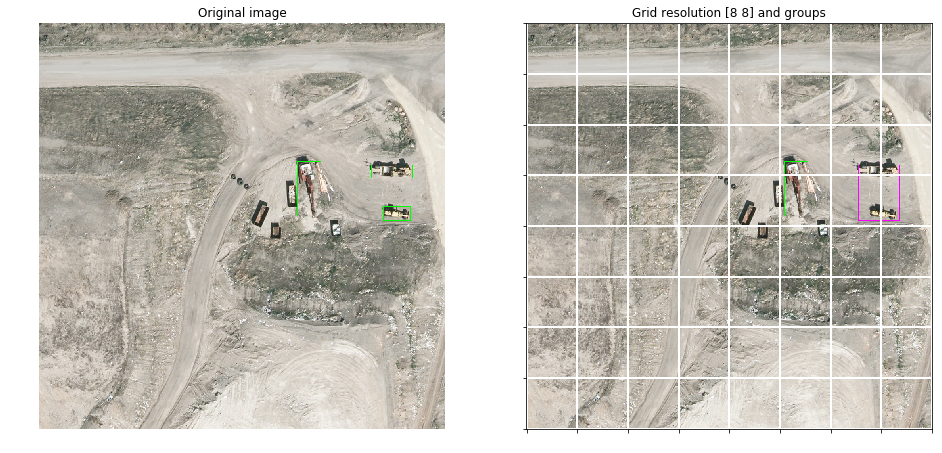

In [22]:
with tf.Graph().as_default():
    mode = 'val'
    fold = 1
    metadata = configuration.load_metadata('Data/metadata_vedai_fold%02d.txt' % fold)  
    image_size = 1024
    
    num_cells = np.array([8, 8])
    grid_offsets = configuration.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs, _ = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                      metadata['feature_keys'],
                                      'vedai',
                                      metadata['%s_max_num_bbs' % mode],
                                      num_classes=len(metadata['data_classes']),
                                      with_classes=True,
                                      with_groups=True,
                                      grid_offsets=grid_offsets,
                                      data_augmentation_threshold=0.5,
                                      image_folder=metadata['image_folder'],
                                      batch_size=1,
                                      image_size=image_size,
                                      shuffle_buffer=1000,
                                      verbose=2)
    inputs = inputs[0]

    with tf.Session() as sess:
        ## Get inputs batch
        inputs_ = sess.run(inputs)
        
        ## Display
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_title('Original image')
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.set_title('Grid resolution %s and groups' % num_cells)
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom=False, labelleft=False) 
        ax2.grid(color='white', linewidth=2)
        plt.show()

# SDD

--- 


60 videos, at most 1024x1024pixels, 12 objects per image on average [[link]](http://cvgl.stanford.edu/projects/uav_data/)

### Load images and annotations from videos

In [4]:
import cv2
sdd_classes_index = {'Biker': 0, 'Bus': 1, 'Car': 2, 'Cart': 3, 'Pedestrian': 4, 'Skater': 5}
sdd_classes = sorted(sdd_classes_index.keys())

def get_annotations(data_dir, setting, video, step=1):
    """Load annotation
    
    Args:
        data_dir: Base data directory
        setting: name of the setting, e.g. bookstore
        video: number of the video to load
        step: Only load annotations for every %step frame
        
    Returns:
        a dictionnary mapping a frame id to a bounding box, a bool whether the annotation is occluded 
        or not ("hard") and its class
    """
    global sdd_classes_index
    labels = os.path.join(data_dir, 'annotations', setting, 'video%d' % video, 'annotations.txt')
    annotations = defaultdict(lambda: [])
    with open(labels, 'r') as f:
        for line in f.read().splitlines():
            aux = shlex.split(line)
            frame = int(aux[5])
            if not frame % step == 0:
                continue
            bbox = map(int, aux[1:5])
            cl = sdd_classes_index[aux[9]]
            if not int(aux[6]) and not int(aux[7]): # exclude out of view and interpolated annots
                annotations[frame].append(list(bbox) + [cl])
    return annotations  


def load_sdd(data_dir, setting, video, index, image_ids, image_annotations,
             output_dir, image_size=1024, step=40):
    """Load and format SDD annotation for a given video
    
    Args:
        data_dir: Base data directory
        setting: name of the setting, e.g. bookstore
        video: number of the video to load
        index: Index of the video in the dataset, used to attribute a unique image id
        image_ids: List to accumulate image ids of the samples
        image_annotations: Triple of lists (num_boxes, bounding_boxes, classes) to accumulate the 
            annotations of the samples
        output_dir: Save the frame image in the given directory with the corresponding id
        image_size: used to resize and save the image
        step: Only load annotations for every %step frame
    
    """
    # Read the annotation
    annotations = get_annotations(data_dir, setting, video_id, step=step)
    # Open the video
    video_path = os.path.join(data_dir, 'videos', setting, 'video%d' % video, 'video.mov')
    cap = cv2.VideoCapture(video_path)
    cap.open(video_path)
    num_frame = 0
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if  not ret: break
            if num_frame % step == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # image id: video index and frame index
                im_id = '%02d%06d' % (index, num_frame)
                image_ids.append(int(im_id))
                # pad and save image
                im_path = os.path.join(output_dir, '%s.jpeg' % im_id)
                height, width = frame.shape[:2]
                size = max(height, width)
                pad_x, pad_y = size - height, size - width
                pads = ((floor(pad_x / 2), ceil(pad_x / 2)), 
                        (floor(pad_y / 2), ceil(pad_y / 2)),
                        (0, 0))
                frame = np.pad(frame, pads, 'constant')
                frame = resize(frame, (image_size, image_size))
                cv2.imwrite(im_path, frame)
                # Save annotations
                num_boxes = len(annotations[num_frame])
                image_annotations[0].append(num_boxes)
                if num_boxes > 0:
                    boxes = np.stack([bbox[:4] for bbox in annotations[num_frame]], axis=0).astype(np.float32)
                    boxes += np.array([pads[1][0], pads[0][0], pads[1][0], pads[0][0]], dtype=np.float32)
                    boxes /= float(size)
                    classes = np.stack([bbox[-1] for bbox in annotations[num_frame]], axis=0)
                else:
                    boxes = np.array(())
                    classes = np.array(())
                image_annotations[1].append(boxes)
                image_annotations[2].append(classes)
            num_frame += 1            
    except KeyboardInterrupt:
        print('Interrupted at frame', num_frame)
    finally:
        cap.release()

In [5]:
%%time
data_dir = os.path.expanduser('~/Datasets/stanford_campus_dataset/')
output_dir = os.path.expanduser('~/Datasets/sdd_images/')
step = 40

stanford_image_ids = {}
stanford_image_annotations = {}

index = 1
settings = ['bookstore', 'coupa', 'deathCircle', 'gates', 'hyang', 'little', 'nexus', 'quad']
for i, setting in enumerate(settings):
    stanford_image_annotations[setting] = [[], [], []]
    stanford_image_ids[setting] = []
    dir = os.path.join(data_dir, 'videos', setting)
    videos = sorted(os.listdir(dir))
    for j, video in enumerate(videos):
        video_id = int(video[5:])
        print('\rLoading setting %s (%d/%d), video %d (%d/%d)%s' % (
            setting, i + 1, len(settings), video_id, j + 1, len(videos), ' ' * 10), end='')
        load_sdd(data_dir, setting, video_id, index, stanford_image_ids[setting], 
                 stanford_image_annotations[setting], output_dir, step=step)
        index += 1
print()
print('Retrieved', index, 'videos')

Loading setting bookstore (1/8), video 0 (1/7)          

/mnt/nfs/clustersw/Debian/stretch/python/3.6.6-2/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Loading setting quad (8/8), video 3 (4/4)                 
Retrieved 61 videos
CPU times: user 2h 51min 42s, sys: 13min 24s, total: 3h 5min 6s
Wall time: 3h 49min 14s


### Generate the train/val/test split

In [8]:
### Skip this if pre-generated split
## Generate Train / test / val uniformly across setting
train_prop = 0.7
val_prop = 0.05
test_prop = 0.25
    
train_split = []
val_split = []
test_split = []
for key in settings:
    num_samples = len(stanford_image_ids[key])
    shuffled_ids = np.copy(stanford_image_ids[key])
    np.random.shuffle(shuffled_ids)
    num_train_samples = int(num_samples * train_prop)
    num_val_samples = int(num_samples * val_prop)
    train_split.extend(list(shuffled_ids[:num_train_samples]))
    val_split.extend(list(shuffled_ids[num_train_samples:num_train_samples + num_val_samples]))
    test_split.extend(list(shuffled_ids[num_train_samples + num_val_samples:]))
    
print('%d training samples' % len(train_split))
print('%d validation samples' % len(val_split))
print('%d test samples' % len(test_split))

for key, split in [('train', train_split), ('val', val_split), ('test', test_split)]:
    with open('./Data/sdd_%s_split.txt' % key, 'w') as f:
        f.write('\n'.join(map(str, split)))

9163 training samples
651 validation samples
3281 test samples


In [9]:
## Or load pregenerated splits
with open('Data/sdd_train_split.txt', 'r') as f:
    train_split = list(map(int, f.readlines()))
    
with open('Data/sdd_val_split.txt', 'r') as f:
    val_split = list(map(int, f.readlines()))
    
with open('Data/sdd_test_split.txt', 'r') as f:
    test_split = list(map(int, f.readlines()))

### Write to TFRecords

In [10]:
# Flatten
image_ids = []
image_annotations = [[], [], []]
for setting in settings:
    image_ids.extend(stanford_image_ids[setting])    
    image_annotations[0].extend(stanford_image_annotations[setting][0])
    image_annotations[1].extend(stanford_image_annotations[setting][1])
    image_annotations[2].extend(stanford_image_annotations[setting][2])

In [11]:
stanford_max_num_bbs = max(image_annotations[0])
print('Loaded', len(image_ids), 'samples')
print(stanford_max_num_bbs, 'max num bbs')
print(np.mean(image_annotations[0]), 'average num bbs')

Loaded 13095 samples
100 max num bbs
12.071401298205421 average num bbs


In [14]:
%%time
num_samples = {}
paths = {}
for name, split in [('train', train_split), ('val', val_split), ('test', test_split)]:
    path = 'Data/sdd_%s' % name
    num_split_samples, feature_keys = write_data_to_tfrecords(
        image_ids, image_annotations, path, pad=stanford_max_num_bbs, split=split)
    paths[name] = path
    num_samples[name] = num_split_samples
    print('Wrote', num_samples[name], name, 'examples')
    print()
    
with open('Data/metadata_sdd.txt', 'w') as f:
    for name in ['train', 'val', 'test']:
        f.write('%s_tfrecords\t%s\n' % (name, paths[name]))
        f.write('%s_max_num_bbs\t%s\n' % (name, stanford_max_num_bbs))
        f.write('%s_num_samples\t%s\n' % (name, num_samples[name]))
    f.write('data_classes\t%s\n' % ','.join(sdd_classes))
    f.write('feature_keys\t%s\n' % ','.join(feature_keys))
    f.write('image_folder\t%s\n' % output_dir)

Wrote 9163 train examples

Wrote 651 val examples

Wrote 3281 test examples

CPU times: user 6.66 s, sys: 34.5 ms, total: 6.69 s
Wall time: 9.91 s


### Test the input pipeline + on-the-fly groups


In-graph inputs:
 > load_inputs
    bounding_boxes: shape=[None, 100, 4], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 8, 8, 1, 4], dtype=<dtype: 'float32'>
    im_id: shape=[None], dtype=<dtype: 'int32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>
    image: shape=[None, 512, 512, 3], dtype=<dtype: 'float32'>
    group_flags: shape=[None, 8, 8, 1, 1], dtype=<dtype: 'float32'>
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    class_labels: shape=[None, 100, 6], dtype=<dtype: 'int32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    obj_i_mask_bbs: shape=[None, 8, 8, 1, 100], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 8, 8, 1, 6], dtype=<dtype: 'int32'>

Sample:
    im_id: 1002480
    grid size [8 8]
    13 bbs
    12 bbs after grouping
    Classes: Pedestrian, Pedestrian, Pedestrian, Pedestrian, Pedestrian, Biker, Biker, Biker, Skater, Biker, Biker, Pedestrian, Pedestrian
    Group classes: Skater, Biker, Bik

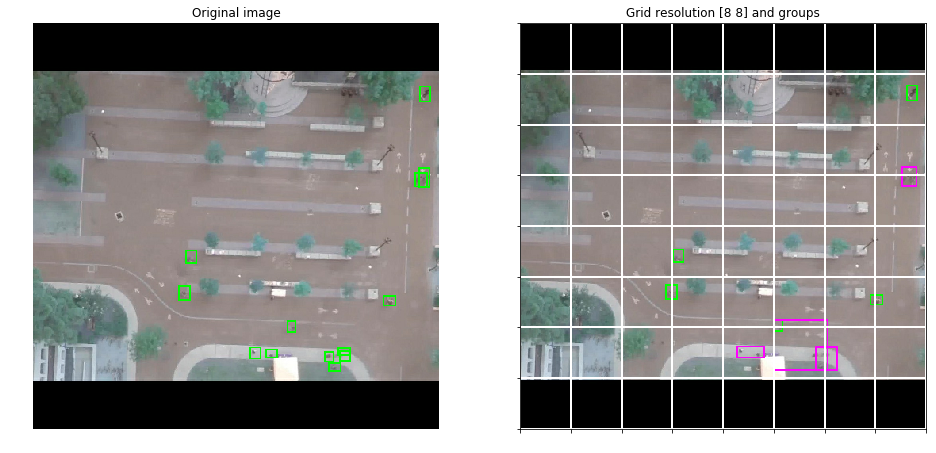

In [24]:
with tf.Graph().as_default():
    mode = 'train'
    metadata = configuration.load_metadata('Data/metadata_sdd.txt')  
    image_size = 512
    
    num_cells = np.array([8, 8])
    grid_offsets = configuration.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs, _ = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                         metadata['feature_keys'],
                                         'sdd',
                                         metadata['%s_max_num_bbs' % mode],
                                         num_classes=len(metadata['data_classes']),
                                         with_classes=True,
                                         with_groups=True,
                                         grid_offsets=grid_offsets,
                                         data_augmentation_threshold=1.,
                                         image_folder=metadata['image_folder'],
                                         batch_size=1,
                                         image_size=image_size,
                                         shuffle_buffer=100,
                                         verbose=2)
    inputs = inputs[0]

    with tf.Session() as sess:
        inputs_ = sess.run(inputs)
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_title('Original image')
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.set_title('Grid resolution %s and groups' % num_cells)
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom=False, labelleft=False) 
        ax2.grid(color='white', linewidth=2)
        plt.show()

# MSCOCO 2017

---

http://cocodataset.org/#home

In [9]:
import json

class COCOInstances:    
    def __init__(self, 
                 instance_annotations_file,
                 image_folder,
                 stuff_annotations_file=None):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        
        Args:
            `instance_annotation_file`: string location of object instances annotation file.
            `image_folder`: string location to the folder that hosts images.
            `stuff_annotation_file`: string location of stuff instances annotation file. Optional.
        """
        # Load dataset
        print('Loading instance annotations into memory...')
        dataset = (json.load(open(instance_annotations_file, 'r')))
        print('Annotations loaded!')
        
        # Load images
        self.images = {x['id']: {k: x[k] for k in ['file_name', 'height', 'width']}
                       for x in dataset['images']}
        self.image_folder = image_folder
        
        # Load Instance annotations       
        categories = {x['id']: {k: x[k] for k in ['name', 'supercategory']}
                      for x in dataset['categories']}
        annotations = dataset['annotations']
        
        # Load stuff annotations
        if stuff_annotations_file is not None:
            print('Loading stuff annotations into memory...')
            dataset = (json.load(open(stuff_annotations_file, 'r')))
            print('Annotations loaded!')
            categories.update({x['id']: {k: x[k] for k in ['name', 'supercategory']}
                               for x in dataset['categories']})
            annotations.extend(dataset['annotations'])
            
        # Link images to annotations
        self.image_to_annotations = defaultdict(lambda: [])
        self.categories = categories
        for annot in annotations:
            self.image_to_annotations[annot['image_id']].append(
                {k: int(annot[k]) if k != 'bbox' else list(map(int, annot[k]))
                 for k in ['area', 'bbox', 'category_id', 'id', 'iscrowd']})
            
        
    def getImageIds(self, cat_id=None):
        """Get image IDs from annotations.  One can use params to get filtered results.
        
        Args: 
            `cat_id`: list of categories id to fitler on
            If params is empty, return all image IDs in the dataset.
        """
        if cat_id is None:
            return list(self.images.keys())
        else:
            assert isinstance(cat_id, list)
            return [k for k in self.images.keys() 
                    if any(x['category_id'] in set(cat_id) for x in self.image_to_annotations[k])]
    
    
    def getImagePath(self, im_id):
        """Return path to the image for the given `im_id`"""
        im = self.images[im_id]
        return os.path.join(self.image_folder, im['file_name'])

In [87]:
def load_coco(base_dir, split='train'):
    coco = COCOInstances(os.path.join(base_dir, 'annotations/instances_%s2017.json' % split),
                         os.path.join(base_dir, 'images/%s2017' % split))
    mscoco_classes = [coco.categories[key]['name'] if key in coco.categories else 'None' 
                      for key in range(1, 91)]
    image_ids = coco.getImageIds()
    max_num_bbs = 0
    # num_boxes, bbs, classes
    image_annotations = [[], [], []]
    for im_id in image_ids:
        width = coco.images[im_id]['width']
        height = coco.images[im_id]['height']
        annot = coco.image_to_annotations[im_id]
        num_boxes = len(annot)
        bbs = []
        classes = []
        for a in annot:
            classes.append(a['category_id'] - 1)
            x = a['bbox'][0] / width
            y = a['bbox'][1] / height
            w = a['bbox'][2] / width
            h = a['bbox'][3] / height
            bbs.append([x, y, x + w, y + h])
        # append
        max_num_bbs = max(max_num_bbs, num_boxes)
        image_annotations[0].append(num_boxes)
        image_annotations[1].append(np.array(bbs, dtype=np.float32))
        image_annotations[2].append(np.array(classes, dtype=np.int32))
    return image_ids, image_annotations, max_num_bbs, mscoco_classes

In [109]:
%%time
(mscoco_train_image_ids, 
 mscoco_train_image_annotations,
 mscoco_train_max_num_bbs,
 mscoco_classes) = load_coco(os.path.expanduser('~/Datasets/MSCOCO_2017/'), split='train')

train_split = mscoco_train_image_ids[:-5000]
val_split = mscoco_train_image_ids[-5000:]

(mscoco_test_image_ids, 
 mscoco_test_image_annotations,
 mscoco_test_max_num_bbs,
 _) = load_coco(os.path.expanduser('~/Datasets/MSCOCO_2017/'), split='val')

test_split = None
mscoco_max_num_bbs = max(mscoco_train_max_num_bbs, mscoco_test_max_num_bbs)
mscoco_image_folder = os.path.expanduser('~/Datasets/MSCOCO_2017/images')

Loading instance annotations into memory...
Annotations loaded!
Loading instance annotations into memory...
Annotations loaded!
CPU times: user 27.7 s, sys: 2.32 s, total: 30 s
Wall time: 29.3 s


In [110]:
paths = {}
num_samples = {}
for name, split in [('train', train_split), ('val', val_split), ('test', test_split)]:
    path = 'Data/mscoco_%s' % name
    num_split_samples, feature_keys = write_data_to_tfrecords(
        mscoco_train_image_ids if name in ['train', 'val'] else mscoco_test_image_ids,
        mscoco_train_image_annotations if name in ['train', 'val'] else  mscoco_test_image_annotations,
        path, 
        pad=mscoco_max_num_bbs,
        split=split)
    paths[name] = path
    num_samples[name] = num_split_samples
    print('Wrote', num_samples[name], name, 'examples')
    print()

with open('Data/metadata_mscoco.txt', 'w') as f:
    for name in ['train', 'val', 'test']:
        f.write('%s_tfrecords\t%s\n' % (name, paths[name]))
        f.write('%s_max_num_bbs\t%s\n' % (name, mscoco_max_num_bbs))
        f.write('%s_num_samples\t%s\n' % (name, num_samples[name]))
    f.write('data_classes\t%s\n' % ','.join(mscoco_classes))
    f.write('feature_keys\t%s\n' % ','.join(feature_keys))
    f.write('image_folder\t%s\n' % mscoco_image_folder)

Wrote 113287 train examples

Wrote 5000 val examples

Wrote 5000 test examples




In-graph inputs:
 > load_inputs
    im_id: shape=[None], dtype=<dtype: 'int32'>
    class_labels: shape=[None, 93, 90], dtype=<dtype: 'int32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>
    bounding_boxes: shape=[None, 93, 4], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 13, 13, 1, 4], dtype=<dtype: 'float32'>
    group_flags: shape=[None, 13, 13, 1, 1], dtype=<dtype: 'float32'>
    obj_i_mask_bbs: shape=[None, 13, 13, 1, 93], dtype=<dtype: 'float32'>
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    image: shape=[None, 512, 512, 3], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 13, 13, 1, 90], dtype=<dtype: 'int32'>

Sample:
    im_id: 512630
    grid size [13 13]
    2 bbs
    169 bbs after grouping
    Classes: cat, banana
    Group classes: cat, banana, banana


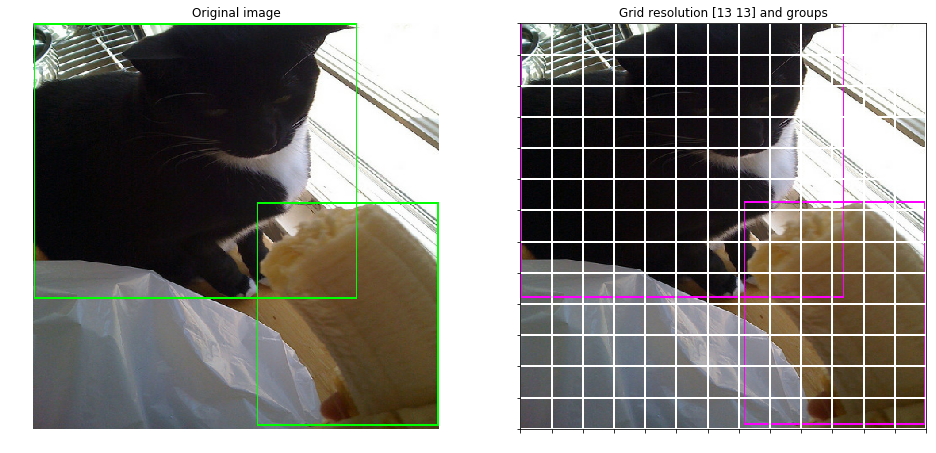

In [118]:
from importlib import reload
reload(tf_inputs)
with tf.Graph().as_default():
    mode = 'val'
    metadata = configuration.load_metadata('Data/metadata_mscoco.txt')  
    image_size = 512
    if mode in ['train', 'val']:
        image_folder = os.path.join(metadata['image_folder'], 'train2017')
    else:
        image_folder = os.path.join(metadata['image_folder'], 'val2017')
    
    num_cells = np.array([13, 13])
    grid_offsets = configuration.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs, _ = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                         metadata['feature_keys'],
                                         'mscoco',
                                         metadata['%s_max_num_bbs' % mode],
                                         num_classes=len(metadata['data_classes']),
                                         with_classes=True,
                                         with_groups=True,
                                         grid_offsets=grid_offsets,
                                         data_augmentation_threshold=1.,
                                         image_folder=image_folder,
                                         batch_size=1,
                                         image_size=image_size,
                                         shuffle_buffer=100,
                                         grouping_method='intersect_with_density',
                                         verbose=2)
    inputs = inputs[0]
    with tf.Session() as sess:
        inputs_ = sess.run(inputs)
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_title('Original image')
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.set_title('Grid resolution %s and groups' % num_cells)
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom=False, labelleft=False) 
        ax2.grid(color='white', linewidth=2)
        plt.show()